# TRAINING FACE MASK DATASET

## IMPORTING NECESSARY LIBRARIES

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os


### Mounting Drive & Importing DataSet

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [7]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
directory="D:/temp/Intro to dl/data"
categories=["with_mask","without_mask"]


In [8]:
print("[INFO] loading images...")

data = []
labels = []
for imagePath in categories:
    path=os.path.join(directory,imagePath)
    for img in os.listdir(path):
        img_path=os.path.join(path,img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(imagePath)



[INFO] loading images...


### PERFORMING ONE HOT ENCODING

In [9]:

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)




### PARTIONING THE DATA INTO TRAINING AND TESTING SPLITS

In [10]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)


aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")



In [6]:
#M1

baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


[INFO] compiling model...


C:\Users\lmakkapa\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


[INFO] compiling model...


In [8]:
# print("[INFO] training head...")
# H = model.fit(
#     aug.flow(trainX, trainY, batch_size=BS),
#     steps_per_epoch=len(trainX) // BS,
#     validation_data=(testX, testY),
#     validation_steps=len(testX) // BS,
#     epochs=10)

# # make predictions on the testing set
# print("[INFO] evaluating network...")
# predIdxs = model.predict(testX, batch_size=BS)



In [9]:
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    
    epochs=10)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] training head...
Epoch 1/10
188/188 [==============================] - 184s 964ms/step - loss: 0.2792 - accuracy: 0.9108 - val_loss: 0.0893 - val_accuracy: 0.9775
Epoch 2/10
188/188 [==============================] - 188s 999ms/step - loss: 0.0919 - accuracy: 0.9757 - val_loss: 0.0577 - val_accuracy: 0.9815
Epoch 3/10
188/188 [==============================] - 185s 984ms/step - loss: 0.0668 - accuracy: 0.9810 - val_loss: 0.0513 - val_accuracy: 0.9835
Epoch 4/10
188/188 [==============================] - 185s 985ms/step - loss: 0.0552 - accuracy: 0.9834 - val_loss: 0.0434 - val_accuracy: 0.9835
Epoch 5/10
188/188 [==============================] - 215s 1s/step - loss: 0.0474 - accuracy: 0.9854 - val_loss: 0.0428 - val_accuracy: 0.9854
Epoch 6/10
188/188 [==============================] - 181s 963ms/step - loss: 0.0420 - accuracy: 0.9865 - val_loss: 0.0408 - val_accuracy: 0.9854
Epoch 7/10
188/188 [==============================] - 185s 984ms/step - loss: 0.0402 - accuracy: 0.9872

In [10]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

### CLASSIFICATION REPORT

In [11]:
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))


              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       745
without_mask       0.99      0.99      0.99       766

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511



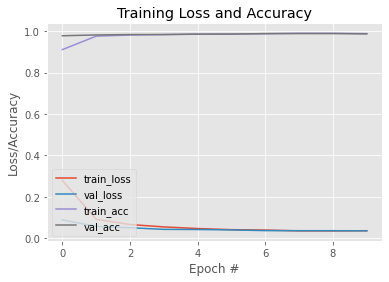

In [12]:
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')

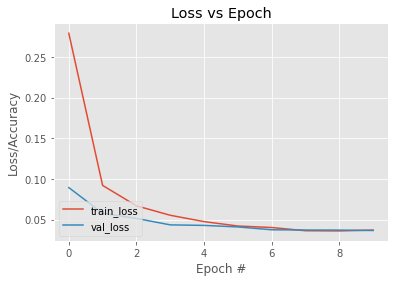

In [14]:

N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Loss vs Epoch")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')

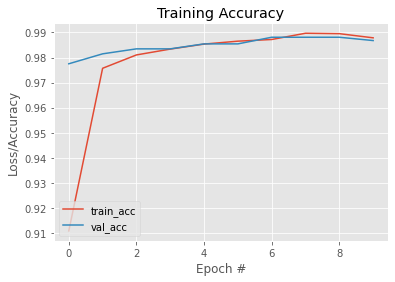

In [15]:
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')

[INFO] training head...
Epoch 1/20
188/188 [==============================] - 177s 939ms/step - loss: 0.0303 - accuracy: 0.9905 - val_loss: 0.0353 - val_accuracy: 0.9881
Epoch 2/20
188/188 [==============================] - 214s 1s/step - loss: 0.0286 - accuracy: 0.9899 - val_loss: 0.0368 - val_accuracy: 0.9901
Epoch 3/20
188/188 [==============================] - 230s 1s/step - loss: 0.0322 - accuracy: 0.9892 - val_loss: 0.0342 - val_accuracy: 0.9868
Epoch 4/20
188/188 [==============================] - 198s 1s/step - loss: 0.0330 - accuracy: 0.9895 - val_loss: 0.0332 - val_accuracy: 0.9887
Epoch 5/20
188/188 [==============================] - 195s 1s/step - loss: 0.0272 - accuracy: 0.9907 - val_loss: 0.0342 - val_accuracy: 0.9894
Epoch 6/20
188/188 [==============================] - 213s 1s/step - loss: 0.0291 - accuracy: 0.9900 - val_loss: 0.0350 - val_accuracy: 0.9894
Epoch 7/20
188/188 [==============================] - 189s 1s/step - loss: 0.0285 - accuracy: 0.9913 - val_loss: 0.

ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

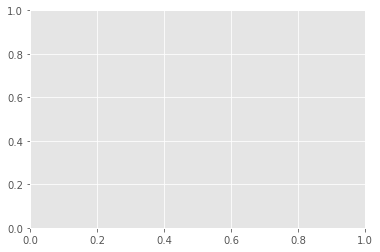

In [16]:
#M2

print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    
    epochs=20)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)



N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')

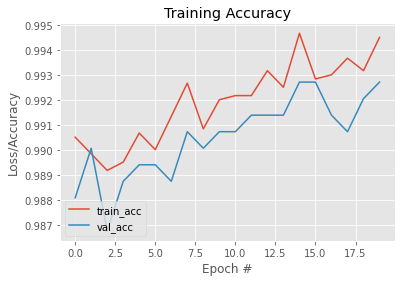

In [17]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')

C:\Users\lmakkapa\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[INFO] compiling model...
[INFO] compiling model...
[INFO] training head...
Epoch 1/10
188/188 [==============================] - 186s 973ms/step - loss: 0.3720 - accuracy: 0.8544 - val_loss: 0.0932 - val_accuracy: 0.9768
Epoch 2/10
188/188 [==============================] - 201s 1s/step - loss: 0.0952 - accuracy: 0.9757 - val_loss: 0.0533 - val_accuracy: 0.9815
Epoch 3/10
188/188 [==============================] - 199s 1s/step - loss: 0.0678 - accuracy: 0.9804 - val_loss: 0.0466 - val_accuracy: 0.9841
Epoch 4/10
188/188 [==============================] - 208s 1s/step - loss: 0.0541 - accuracy: 0.9825 - val_loss: 0.0431 - val_accuracy: 0.9854
Epoch 5/10
188/188 [==============================] - 193s 1s/step - loss: 0.0508 - accuracy: 0.9844 - val_loss: 0.0396 - val_accuracy: 0.9861
Epoch 6/10
188/188 [==============================] - 197s 1s/step - loss: 0.0461 - accuracy: 0.9865 - val_loss: 0.0376 - val_accuracy: 0.9874
Epoch 7/10
188/188 [==============================] - 200s 1s/s

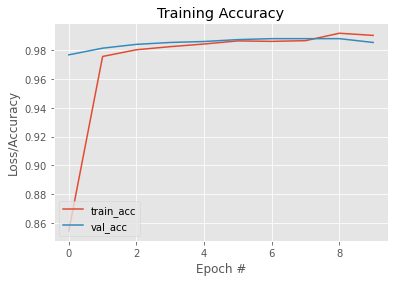

In [18]:
#m3

baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    
    epochs=10)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)



N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')

[INFO] compiling model...
[INFO] compiling model...
[INFO] training head...


C:\Users\lmakkapa\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
188/188 [==============================] - 187s 983ms/step - loss: 0.3254 - accuracy: 0.8817 - val_loss: 0.0792 - val_accuracy: 0.9768
Epoch 2/20
188/188 [==============================] - 202s 1s/step - loss: 0.0965 - accuracy: 0.9732 - val_loss: 0.0507 - val_accuracy: 0.9782
Epoch 3/20
188/188 [==============================] - 207s 1s/step - loss: 0.0602 - accuracy: 0.9834 - val_loss: 0.0432 - val_accuracy: 0.9841
Epoch 4/20
188/188 [==============================] - 228s 1s/step - loss: 0.0527 - accuracy: 0.9824 - val_loss: 0.0430 - val_accuracy: 0.9848
Epoch 5/20
188/188 [==============================] - 216s 1s/step - loss: 0.0473 - accuracy: 0.9867 - val_loss: 0.0376 - val_accuracy: 0.9868
Epoch 6/20
188/188 [==============================] - 209s 1s/step - loss: 0.0423 - accuracy: 0.9865 - val_loss: 0.0356 - val_accuracy: 0.9874
Epoch 7/20
188/188 [==============================] - 283s 2s/step - loss: 0.0436 - accuracy: 0.9852 - val_loss: 0.0350 - val_accuracy: 0.9

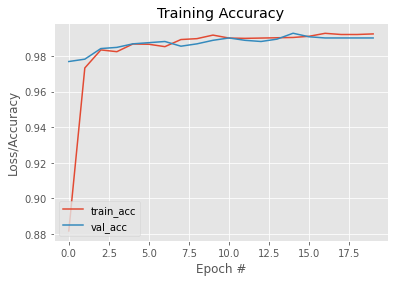

In [19]:
#m4

baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    
    epochs=20)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)



N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')



import visualkeras
visualkeras.layered_view(model)

[INFO] compiling model...
[INFO] compiling model...
[INFO] training head...


C:\Users\lmakkapa\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5
188/188 [==============================] - 202s 1s/step - loss: 0.3032 - accuracy: 0.8963 - val_loss: 0.0920 - val_accuracy: 0.9788
Epoch 2/5
188/188 [==============================] - 216s 1s/step - loss: 0.0976 - accuracy: 0.9710 - val_loss: 0.0604 - val_accuracy: 0.9788
Epoch 3/5
188/188 [==============================] - 207s 1s/step - loss: 0.0695 - accuracy: 0.9797 - val_loss: 0.0509 - val_accuracy: 0.9835
Epoch 4/5
188/188 [==============================] - 209s 1s/step - loss: 0.0610 - accuracy: 0.9822 - val_loss: 0.0473 - val_accuracy: 0.9815
Epoch 5/5
188/188 [==============================] - 197s 1s/step - loss: 0.0500 - accuracy: 0.9860 - val_loss: 0.0462 - val_accuracy: 0.9841
[INFO] evaluating network...
48/48 [==============================] - 33s 679ms/step
              precision    recall  f1-score   support

   with_mask       0.97      0.99      0.98       745
without_mask       0.99      0.98      0.98       766

    accuracy                           0.

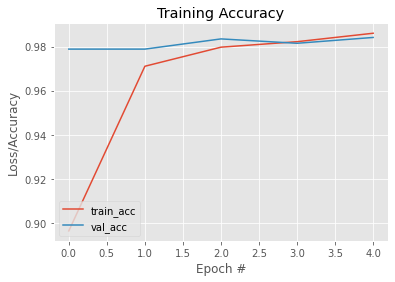

In [8]:
#m5
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    
    epochs=5)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

N = 5
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')


[INFO] compiling model...
[INFO] compiling model...
[INFO] training head...


C:\Users\lmakkapa\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
188/188 [==============================] - 200s 1s/step - loss: 0.3016 - accuracy: 0.8967 - val_loss: 0.0600 - val_accuracy: 0.9782
Epoch 2/20
188/188 [==============================] - 211s 1s/step - loss: 0.0648 - accuracy: 0.9824 - val_loss: 0.0456 - val_accuracy: 0.9821
Epoch 3/20
188/188 [==============================] - 212s 1s/step - loss: 0.0516 - accuracy: 0.9834 - val_loss: 0.0428 - val_accuracy: 0.9841
Epoch 4/20
188/188 [==============================] - 212s 1s/step - loss: 0.0470 - accuracy: 0.9854 - val_loss: 0.0421 - val_accuracy: 0.9821
Epoch 5/20
188/188 [==============================] - 198s 1s/step - loss: 0.0354 - accuracy: 0.9907 - val_loss: 0.0371 - val_accuracy: 0.9854
Epoch 6/20
188/188 [==============================] - 204s 1s/step - loss: 0.0406 - accuracy: 0.9867 - val_loss: 0.0423 - val_accuracy: 0.9881
Epoch 7/20
188/188 [==============================] - 204s 1s/step - loss: 0.0333 - accuracy: 0.9900 - val_loss: 0.0368 - val_accuracy: 0.9881

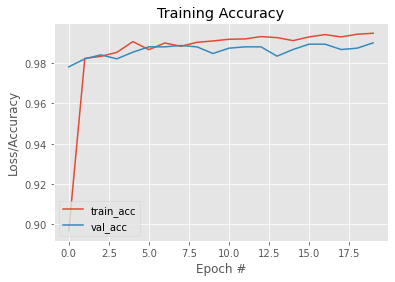

In [10]:
#m6
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    
    epochs=20)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')


In [ ]:
CNN


[INFO] training head...
Epoch 1/10
188/188 [==============================] - 84s 444ms/step - loss: 1.3279 - accuracy: 0.3809 - val_loss: 0.7934 - val_accuracy: 0.3157
Epoch 2/10
188/188 [==============================] - 92s 491ms/step - loss: 0.9080 - accuracy: 0.3213 - val_loss: 0.9657 - val_accuracy: 0.2919
Epoch 3/10
188/188 [==============================] - 88s 466ms/step - loss: 1.1260 - accuracy: 0.3300 - val_loss: 1.2733 - val_accuracy: 0.3190
Epoch 4/10
188/188 [==============================] - 89s 473ms/step - loss: 1.0284 - accuracy: 0.3356 - val_loss: 1.0447 - val_accuracy: 0.3607
Epoch 5/10
188/188 [==============================] - 84s 448ms/step - loss: 1.0105 - accuracy: 0.3669 - val_loss: 0.7036 - val_accuracy: 0.3157
Epoch 6/10
188/188 [==============================] - 89s 473ms/step - loss: 0.7438 - accuracy: 0.3314 - val_loss: 0.6930 - val_accuracy: 0.3084
Epoch 7/10
188/188 [==============================] - 92s 488ms/step - loss: 0.6803 - accuracy: 0.2935 - v

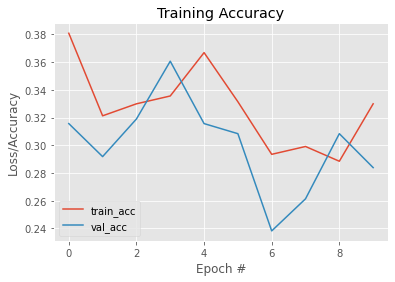

In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import img_to_array
from keras.utils import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import keras
from tensorflow.python.keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf

model = keras.Sequential()
model.add(Flatten(input_shape=(224,224,3)))
model.add(Dense(128, activation='relu'))
model.add(Dense(2))
# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(Flatten())
# model.add(Dense(units=64,activation="relu"))
# model.add(Dense(units=32,activation="relu"))
# model.add(Dense(units=2, activation="softmax"))

from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    
    epochs=10)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')


[INFO] training head...
Epoch 1/10
188/188 [==============================] - 80s 420ms/step - loss: 0.9969 - accuracy: 0.4722 - val_loss: 0.8097 - val_accuracy: 0.5103
Epoch 2/10
188/188 [==============================] - 89s 472ms/step - loss: 0.7934 - accuracy: 0.5180 - val_loss: 0.8566 - val_accuracy: 0.5281
Epoch 3/10
188/188 [==============================] - 88s 466ms/step - loss: 0.8121 - accuracy: 0.5115 - val_loss: 0.7571 - val_accuracy: 0.5063
Epoch 4/10
188/188 [==============================] - 92s 490ms/step - loss: 0.8218 - accuracy: 0.4975 - val_loss: 0.7462 - val_accuracy: 0.4732
Epoch 5/10
188/188 [==============================] - 96s 511ms/step - loss: 0.7963 - accuracy: 0.4800 - val_loss: 0.8027 - val_accuracy: 0.4606
Epoch 6/10
188/188 [==============================] - 95s 505ms/step - loss: 0.7998 - accuracy: 0.4097 - val_loss: 0.6134 - val_accuracy: 0.3475
Epoch 7/10
188/188 [==============================] - 99s 525ms/step - loss: 0.6057 - accuracy: 0.3228 - v

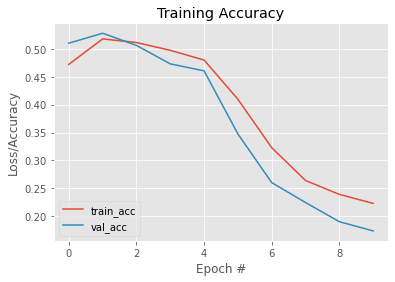

In [24]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import img_to_array
from keras.utils import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import keras
from tensorflow.python.keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf

model = keras.Sequential()
model.add(Flatten(input_shape=(224,224,3)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2))



# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(Flatten())
# model.add(Dense(units=64,activation="relu"))
# model.add(Dense(units=32,activation="relu"))
# model.add(Dense(units=2, activation="softmax"))

from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    
    epochs=10)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.whats is ablock in mhistory["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')


In [ ]:
#   layers.Rescaling(1./255, input_shape=(28,28,1)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(128, activation='relu'),


from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import img_to_array
from keras.utils import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import keras
from tensorflow.python.keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf

model = keras.Sequential()


model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=2, activation="softmax"))


# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(Flatten())
# model.add(Dense(units=64,activation="relu"))
# model.add(Dense(units=32,activation="relu"))
# model.add(Dense(units=2, activation="softmax"))

from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    
    epochs=10)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')


[INFO] training head...
Epoch 1/10
171/188 [==========================>...] - ETA: 1:33 - loss: 0.8056 - accuracy: 0.7881

In [ ]:
#6
#   layers.Rescaling(1./255, input_shape=(28,28,1)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(128, activation='relu'),


from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import img_to_array
from keras.utils import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import keras
from tensorflow.python.keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf

model = keras.Sequential()



mode.add(Rescaling(1./255, input_shape=(224,224,3)))
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(2, activation='relu')



# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Flatten())
# model.add(Dense(units=2, activation="softmax"))


# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(Flatten())
# model.add(Dense(units=64,activation="relu"))
# model.add(Dense(units=32,activation="relu"))
# model.add(Dense(units=2, activation="softmax"))

from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    
    epochs=10)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')


C:\Users\lmakkapa\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[INFO] compiling model...
[INFO] training head...
Epoch 1/10
188/188 [==============================] - 173s 898ms/step - loss: 0.7886 - accuracy: 0.5040 - val_loss: 0.6839 - val_accuracy: 0.5778
Epoch 2/10
188/188 [==============================] - 162s 860ms/step - loss: 0.6777 - accuracy: 0.6153 - val_loss: 0.6586 - val_accuracy: 0.6671
Epoch 3/10
188/188 [==============================] - 173s 918ms/step - loss: 0.6485 - accuracy: 0.6626 - val_loss: 0.6117 - val_accuracy: 0.7591
Epoch 4/10
188/188 [==============================] - 172s 917ms/step - loss: 0.6036 - accuracy: 0.7285 - val_loss: 0.5490 - val_accuracy: 0.7981
Epoch 5/10
188/188 [==============================] - 177s 938ms/step - loss: 0.5561 - accuracy: 0.7544 - val_loss: 0.4889 - val_accuracy: 0.8359
Epoch 6/10
188/188 [==============================] - 159s 844ms/step - loss: 0.5338 - accuracy: 0.7810 - val_loss: 0.4892 - val_accuracy: 0.8412
Epoch 7/10
188/188 [==============================] - 172s 913ms/step - lo

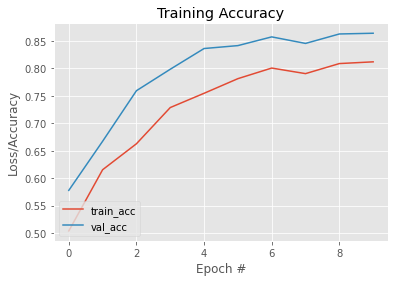

In [11]:

#5


#   layers.Rescaling(1./255, input_shape=(28,28,1)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(128, activation='relu'),

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Rescaling
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import img_to_array
from keras.utils import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import keras
from tensorflow.python.keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from keras.optimizers import Adam
opt = Adam(lr=0.001)

model = keras.Sequential()



model.add(Rescaling(1./255, input_shape=(224,224,3)))
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(2, activation='relu'))



# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Flatten())
# model.add(Dense(units=2, activation="softmax"))


# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(Flatten())
# model.add(Dense(units=64,activation="relu"))
# model.add(Dense(units=32,activation="relu"))
# model.add(Dense(units=2, activation="softmax"))


# model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])


print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])





print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    
    epochs=10)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')


C:\Users\lmakkapa\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[INFO] compiling model...
[INFO] training head...
Epoch 1/10
188/188 [==============================] - 159s 843ms/step - loss: 0.8450 - accuracy: 0.4990 - val_loss: 0.6939 - val_accuracy: 0.5069
Epoch 2/10
188/188 [==============================] - 171s 908ms/step - loss: 0.6926 - accuracy: 0.5138 - val_loss: 0.6896 - val_accuracy: 0.5685
Epoch 3/10
188/188 [==============================] - 157s 835ms/step - loss: 0.6884 - accuracy: 0.5621 - val_loss: 0.6824 - val_accuracy: 0.6764
Epoch 4/10
188/188 [==============================] - 157s 834ms/step - loss: 0.6773 - accuracy: 0.6288 - val_loss: 0.6579 - val_accuracy: 0.7882
Epoch 5/10
188/188 [==============================] - 163s 867ms/step - loss: 0.6377 - accuracy: 0.7150 - val_loss: 0.5809 - val_accuracy: 0.8008
Epoch 6/10
188/188 [==============================] - 154s 817ms/step - loss: 0.5559 - accuracy: 0.7567 - val_loss: 0.4858 - val_accuracy: 0.8061
Epoch 7/10
188/188 [==============================] - 173s 922ms/step - lo

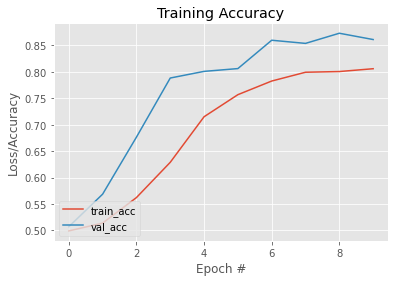

In [12]:


#4

#   layers.Rescaling(1./255, input_shape=(28,28,1)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(128, activation='relu'),

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Rescaling
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import img_to_array
from keras.utils import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import keras
from tensorflow.python.keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from keras.optimizers import Adam
opt = Adam(lr=0.001)

model = keras.Sequential()



model.add(Rescaling(1./255, input_shape=(224,224,3)))
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(2, activation='relu'))



# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Flatten())
# model.add(Dense(units=2, activation="softmax"))


# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(Flatten())
# model.add(Dense(units=64,activation="relu"))
# model.add(Dense(units=32,activation="relu"))
# model.add(Dense(units=2, activation="softmax"))


# model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])


print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])





print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    
    epochs=10)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')


C:\Users\lmakkapa\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[INFO] compiling model...
[INFO] training head...
Epoch 1/10
188/188 [==============================] - 194s 1s/step - loss: 0.8661 - accuracy: 0.5180 - val_loss: 0.6776 - val_accuracy: 0.5242
Epoch 2/10
188/188 [==============================] - 174s 922ms/step - loss: 0.6513 - accuracy: 0.6622 - val_loss: 0.5669 - val_accuracy: 0.8491
Epoch 3/10
188/188 [==============================] - 179s 951ms/step - loss: 0.5098 - accuracy: 0.8030 - val_loss: 0.6862 - val_accuracy: 0.6069
Epoch 4/10
188/188 [==============================] - 173s 917ms/step - loss: 0.5985 - accuracy: 0.7772 - val_loss: 0.4092 - val_accuracy: 0.8570
Epoch 5/10
188/188 [==============================] - 174s 926ms/step - loss: 0.6819 - accuracy: 0.7820 - val_loss: 0.4586 - val_accuracy: 0.8577
Epoch 6/10
188/188 [==============================] - 185s 982ms/step - loss: 0.4871 - accuracy: 0.8128 - val_loss: 0.3922 - val_accuracy: 0.8723
Epoch 7/10
188/188 [==============================] - 176s 935ms/step - loss:

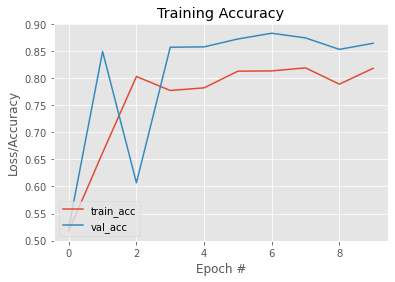

In [13]:

#3


#   layers.Rescaling(1./255, input_shape=(28,28,1)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(128, activation='relu'),

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Rescaling
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import img_to_array
from keras.utils import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import keras
from tensorflow.python.keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from keras.optimizers import Adam
opt = Adam(lr=0.001)

model = keras.Sequential()



model.add(Rescaling(1./255, input_shape=(224,224,3)))
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(2, activation='relu'))



# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Flatten())
# model.add(Dense(units=2, activation="softmax"))


# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(Flatten())
# model.add(Dense(units=64,activation="relu"))
# model.add(Dense(units=32,activation="relu"))
# model.add(Dense(units=2, activation="softmax"))


# model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])


print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])





print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    
    epochs=10)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')


C:\Users\lmakkapa\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[INFO] compiling model...
[INFO] training head...
Epoch 1/5
188/188 [==============================] - 157s 835ms/step - loss: 4.3493 - accuracy: 0.4932 - val_loss: 4.2532 - val_accuracy: 0.4931
Epoch 2/5
188/188 [==============================] - 153s 814ms/step - loss: 4.2467 - accuracy: 0.4937 - val_loss: 4.2469 - val_accuracy: 0.4931
Epoch 3/5
188/188 [==============================] - 155s 823ms/step - loss: 4.2408 - accuracy: 0.4935 - val_loss: 4.2380 - val_accuracy: 0.4931
Epoch 4/5
188/188 [==============================] - 158s 837ms/step - loss: 4.2287 - accuracy: 0.4937 - val_loss: 4.2235 - val_accuracy: 0.4931
Epoch 5/5
188/188 [==============================] - 147s 782ms/step - loss: 4.2119 - accuracy: 0.4933 - val_loss: 4.1897 - val_accuracy: 0.4931
[INFO] evaluating network...
48/48 [==============================] - 8s 162ms/step
              precision    recall  f1-score   support

   with_mask       0.49      1.00      0.66       745
without_mask       0.00      0.0

C:\Users\lmakkapa\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lmakkapa\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lmakkapa\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


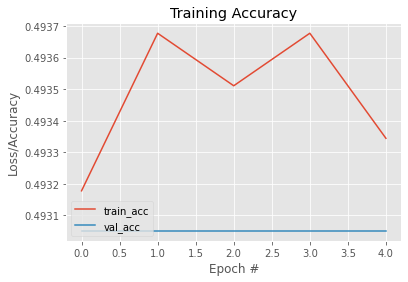

In [14]:
#2



#   layers.Rescaling(1./255, input_shape=(28,28,1)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(128, activation='relu'),

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Rescaling
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import img_to_array
from keras.utils import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import keras
from tensorflow.python.keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from keras.optimizers import Adam
opt = Adam(lr=0.001)

model = keras.Sequential()



model.add(Rescaling(1./255, input_shape=(224,224,3)))
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(2, activation='relu'))



# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Flatten())
# model.add(Dense(units=2, activation="softmax"))


# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(Flatten())
# model.add(Dense(units=64,activation="relu"))
# model.add(Dense(units=32,activation="relu"))
# model.add(Dense(units=2, activation="softmax"))


# model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])


print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])





print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    
    epochs=5)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

N = 5
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')


C:\Users\lmakkapa\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[INFO] compiling model...
[INFO] training head...
Epoch 1/15
188/188 [==============================] - 172s 913ms/step - loss: 0.8596 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.5069
Epoch 2/15
188/188 [==============================] - 150s 796ms/step - loss: 0.6916 - accuracy: 0.5248 - val_loss: 0.6885 - val_accuracy: 0.5248
Epoch 3/15
188/188 [==============================] - 161s 857ms/step - loss: 0.6846 - accuracy: 0.5928 - val_loss: 0.6744 - val_accuracy: 0.6698
Epoch 4/15
188/188 [==============================] - 158s 839ms/step - loss: 0.6555 - accuracy: 0.6614 - val_loss: 0.6183 - val_accuracy: 0.7392
Epoch 5/15
188/188 [==============================] - 160s 849ms/step - loss: 0.5899 - accuracy: 0.7170 - val_loss: 0.5555 - val_accuracy: 0.6942
Epoch 6/15
188/188 [==============================] - 156s 832ms/step - loss: 0.5405 - accuracy: 0.7682 - val_loss: 0.4619 - val_accuracy: 0.8326
Epoch 7/15
188/188 [==============================] - 155s 822ms/step - lo

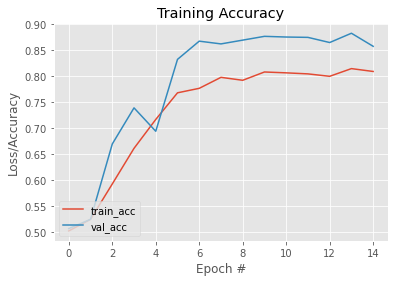

In [15]:
#1



#   layers.Rescaling(1./255, input_shape=(28,28,1)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(128, activation='relu'),

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Rescaling
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import img_to_array
from keras.utils import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import keras
from tensorflow.python.keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from keras.optimizers import Adam
opt = Adam(lr=0.001)

model = keras.Sequential()



model.add(Rescaling(1./255, input_shape=(224,224,3)))
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(2, activation='relu'))



# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Flatten())
# model.add(Dense(units=2, activation="softmax"))


# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(Flatten())
# model.add(Dense(units=64,activation="relu"))
# model.add(Dense(units=32,activation="relu"))
# model.add(Dense(units=2, activation="softmax"))


# model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])


print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])





print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    
    epochs=15)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

N = 15
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')
